In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
my_data_dir = '/content/drive/MyDrive/FINAL_TF2_FILES/cell_images'

In [ ]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir)

['test', 'train']

In [ ]:
test_path = my_data_dir+'/test'
train_path = my_data_dir+'/train'

In [ ]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [ ]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [ ]:
os.listdir(train_path+'/parasitized')[0]

'C95P56ThinF_IMG_20150821_171701_cell_98.png'

In [ ]:
para_cell = train_path+'/parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [ ]:
para_img= imread(para_cell)

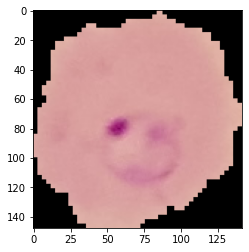

In [ ]:
plt.imshow(para_img)

In [ ]:
para_img.shape

(148, 142, 3)

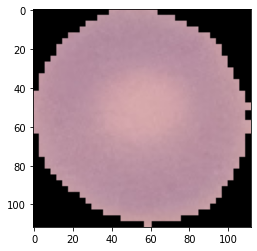

In [ ]:
unifected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[0]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [ ]:
len(os.listdir(train_path+'/parasitized'))

12500

In [ ]:
len(os.listdir(train_path+'/uninfected'))

12490

In [ ]:
unifected_cell.shape

(112, 112, 3)

In [ ]:
para_img.shape

(148, 142, 3)

In [ ]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):

    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


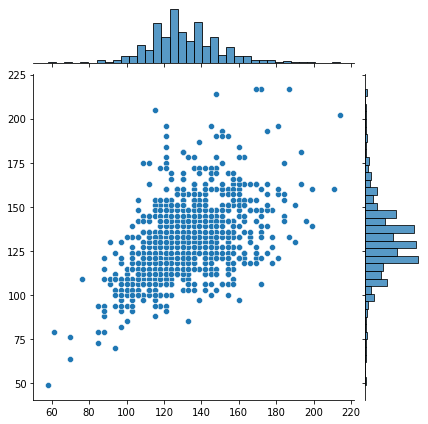

In [ ]:
sns.jointplot(dim1,dim2)

In [ ]:
np.mean(dim1)

130.92538461538462

In [ ]:
np.mean(dim2)

130.75

In [ ]:
image_shape = (130,130,3)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [ ]:
batch_size = 16

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

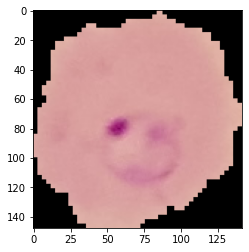

In [ ]:
plt.imshow(para_img)

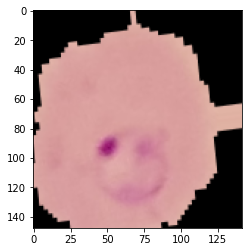

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

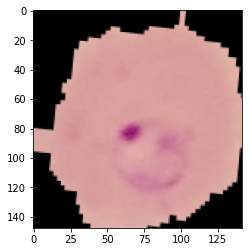

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

In [ ]:
image_gen.flow_from_directory(train_path)

Found 24988 images belonging to 2 classes.


In [ ]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24988 images belonging to 2 classes.


In [ ]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [ ]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Epoch 1/20
1562/1562 [==============================] - 3887s 2s/step - loss: 0.3896 - accuracy: 0.8338 - val_loss: 0.1977 - val_accuracy: 0.9292
Epoch 2/20
1562/1562 [==============================] - 801s 513ms/step - loss: 0.1890 - accuracy: 0.9401 - val_loss: 0.1719 - val_accuracy: 0.9427
Epoch 3/20
1562/1562 [==============================] - 805s 515ms/step - loss: 0.1694 - accuracy: 0.9479 - val_loss: 0.1789 - val_accuracy: 0.9446
Epoch 4/20
1562/1562 [==============================] - 801s 513ms/step - loss: 0.1664 - accuracy: 0.9478 - val_loss: 0.1606 - val_accuracy: 0.9458
Epoch 5/20
1562/1562 [==============================] - 802s 513ms/step - loss: 0.1616 - accuracy: 0.9489 - val_loss: 0.1617 - val_accuracy: 0.9400
Epoch 6/20
1562/1562 [==============================] - 803s 514ms/step - loss: 0.1571 - accuracy: 0.9511 - val_loss: 0.1675 - val_accuracy: 0.9454


In [ ]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')

In [ ]:
losses = pd.DataFrame(model.history.history)

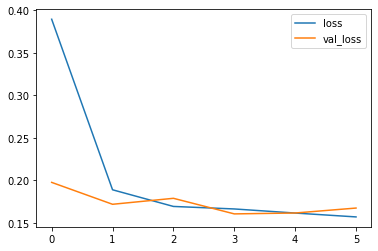

In [ ]:
losses[['loss','val_loss']].plot()

In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
model.evaluate_generator(test_image_gen)

[0.14819806814193726, 0.947692334651947]

In [ ]:
pred_probabilities = model.predict_generator(test_image_gen)

In [ ]:
pred_probabilities

array([[4.1418392e-07],
       [2.6431549e-06],
       [1.8801684e-05],
       ...,
       [9.6260595e-01],
       [9.8340970e-01],
       [9.8516840e-01]], dtype=float32)

In [ ]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [ ]:
predictions = pred_probabilities > 0.5

In [ ]:
# Numpy can treat this as True/False for us
predictions

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1300
           1       0.94      0.95      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [ ]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1220,   80],
       [  68, 1232]])

In [ ]:
para_cell

'/content/drive/MyDrive/FINAL_TF2_FILES/cell_images/train/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
my_image = image.load_img(para_cell,target_size=image_shape)

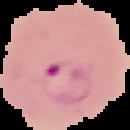

In [ ]:
my_image

In [ ]:
type(my_image)

PIL.Image.Image

In [ ]:
my_image = image.img_to_array(my_image)

In [ ]:
type(my_image)

numpy.ndarray

In [ ]:
my_image.shape

(130, 130, 3)

In [ ]:
my_image = np.expand_dims(my_image, axis=0)

In [ ]:
my_image.shape

(1, 130, 130, 3)

In [ ]:
model.predict(my_image)

array([[0.]], dtype=float32)

In [ ]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}